# Visual aid for manual pump counting

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import os
import pickle
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import extract, util
from pharaglow.util import smooth
from skimage.io import imsave

#### Read in pharaglow results file. Modify as needed to read in your data.

In [4]:
lawns = "/home/nzjacic/Desktop/Harddrive/Lawns/"
file = '/media/soma/Nicolina/GRU101/RFP_5h/10x/10X_GRU101_5hrlawn_analyzed/NZ0191_results_4.json'
movieID = "NZ0191"

print('Reading', file)
particle_index = int(file.split('.')[0].split('_')[-1])
traj =  pd.read_json(file, orient='split')
try:
    lawn = pims.open(os.path.join(lawns, f'{movieID}_lawn.tiff'))[0]
except pims.UnknownFormatError:
     lawn = pims.open(os.path.join(lawns, f'{movieID}_lawn.bmp'))[0]

# break


Reading /media/soma/Nicolina/GRU101/RFP_5h/10x/10X_GRU101_5hrlawn_analyzed/NZ0191_results_4.json


#### make the images all the same shape

In [5]:
def pad(im, shape, size, reshape = True):
    # make image from list
    im = np.array(im, dtype = int)
    if reshape:
        im = im.reshape(-1, shape)
    # pad an image to square
    sy, sx = im.shape
    assert sy<=size, 'Y axis is larger than desired size.'
    assert sx <=size, 'X axis is larger than desired size.'
    # how much to add around each side
    py, px = (size-sy)//2, (size-sx)//2
    # add back the possible rounding error
    oy, ox = (size-sy)%2, (size-sx)%2
    newIm = np.pad(im, [(py, py+oy), (px, px+ox)], mode='constant', constant_values= np.mean(im))
    assert newIm.shape ==(size, size), 'Reshaping failed.'
    return newIm


In [6]:
# size of the new image in pixels
size = 100
ims = np.array([pad(im, shape, size) for im,shape in zip(traj['image'], traj['shapeX'])])
ims = np.array(ims).astype(np.uint8)

#### Save worm movie as tiff (can be watched in fiji)

In [7]:
# save movie to watch in fiji
# imsave('test.tiff', ims)

#### Extract nose tip and lawn image

In [8]:
def cropLawn(im, bbox):
    pad = 0
    ymin, xmin, ymax, xmax  = bbox
    sliced = slice(np.max([0, ymin-pad]), ymax+pad), slice(np.max([0, xmin-pad]), xmax+pad)
    return im[sliced]
# get a small section of lawn around the worm
lawnCrop = [pad(cropLawn(lawn, bbox), None, 100, False) for bbox in traj['slice']]
# get the worms head coordinate
headTip = [[cl[0][0]+bbox[0], cl[0][1]+bbox[1]] for cl,bbox in zip(traj['Centerline'], traj['slice'])] 
headTip = np.array(headTip)

#### Interactive plot for counting pumps

<IPython.core.display.Javascript object>


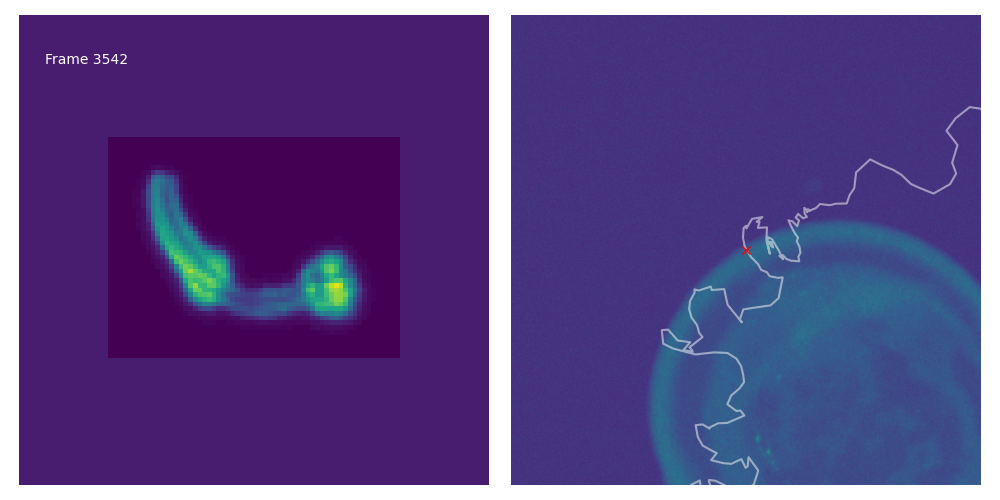

interactive(children=(IntSlider(value=0, description='Frame', max=3286), Output()), _dom_classes=('widget-inte…

Button(description='Pump!', style=ButtonStyle())

In [9]:
%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
# left side shows the worm as tracked by pharaglow
# right plot shows the nose tip (red x) and the whole nose trajectory
# s defines how large the view of the lawn is (2*s, in px)
# adjust vmin and vmax to increase visibility if neccesary

def btn_eventhandler(obj):
#     print(slider.value+offset)
    pumps.append(slider.value+offset)
    

def update(i):
    # this overlays the lawn on top of the left side worm in case its neccesary
    #im1.set_data(ims[i]*0.75+lawnCrop[i]*0.5)
    im1.set_data(ims[i])
    txt.set_text(f'Frame {i+offset}')
    dot.set_xdata(headTip[i,1])
    dot.set_ydata(headTip[i,0])
    ax2.set_xlim(headTip[i,1]-s, headTip[i,1]+s)
    ax2.set_ylim(headTip[i,0]-s, headTip[i,0]+s)
    fig.canvas.draw_idle()
    
# frame offset for counting correctly
offset = traj['frame'].iloc[0]
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax2 = fig.add_subplot(1, 2, 2)
ax2.axis('off')
# initialize plots and set styles
im1 = ax1.imshow(ims[0], vmin=0, vmax=80)
txt = ax1.text(5,10,f'Frame {offset}', color = 'w')
im2 = ax2.imshow(lawn, vmin=0, vmax=150)
ax2.plot(headTip[::10,1],headTip[::10,0], 'w', alpha =0.5)
dot, = ax2.plot(headTip[0,1],headTip[0,0], 'rx')
plt.tight_layout()
s = 300
#interactive plot
slider = widgets.IntSlider(value=0, min=0, max=len(ims)-1,step=1, description='Frame',)
interact(update, i = slider)
# button to save pumps
btn = widgets.Button(description='Pump!')
btn.on_click(btn_eventhandler)
display(btn)
pumps = []





In [11]:
pumps

[2130, 2448, 2973, 3542]